In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

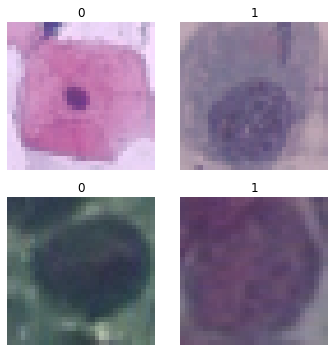

In [2]:
from fastai import *
from fastai.vision import *

path = Path("../pap_smear")
classes = ["normal", "abnormal"]
    
tfms = get_transforms(flip_vert=True, max_warp=0.0, max_zoom=0.5)
data = (ImageList.from_folder(path=path)
       .filter_by_func(lambda fname: "-d" not in fname.name)
       .split_by_rand_pct(valid_pct=0.2)
       .label_from_func(lambda fname: classes.index(fname.parts[-2].split("_")[0]))
       .transform(tfms, size=32)
       .databunch(bs=8)
       .normalize(imagenet_stats))
data.show_batch(rows=2, figsize=(5, 5))

In [3]:
import joblib

In [4]:
train_images = []
train_labels = []

for (x, y) in data.train_ds:
    x = x.data.permute(2, 1, 0).numpy()
    y = y.obj
    train_images.append(x)
    train_labels.append(y)

train_images = np.array(train_images)
train_labels = np.array(train_labels)
print(train_images.shape, train_labels.shape)

(734, 32, 32, 3) (734,)


In [5]:
val_images = []
val_labels = []

for (x, y) in data.valid_ds:
    x = x.data.permute(2, 1, 0).numpy()
    y = y.obj
    val_images.append(x)
    val_labels.append(y)

val_images = np.array(val_images)
val_labels = np.array(val_labels)
print(val_images.shape, val_labels.shape)

(183, 32, 32, 3) (183,)


In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
 
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [7]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
import skimage
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(8, 8),
    cells_per_block=(2,2),
    orientations=9,
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(train_images)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)

In [8]:
X_train_prepared.shape

(734, 324)

In [9]:
X_test_gray = grayify.transform(val_images)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

## SGD Classifier

In [10]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, train_labels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == val_labels)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == val_labels)/len(val_labels))

[False  True False False False  True  True False False  True  True False  True False False False  True False  True
  True  True False  True  True  True]

Percentage correct:  71.5846994535519


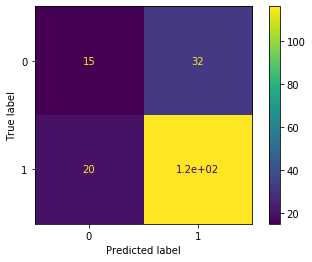

In [12]:
from sklearn import metrics

disp = metrics.plot_confusion_matrix(sgd_clf, X_test_prepared, val_labels)
plt.show(disp)

In [43]:
joblib.dump(sgd_clf, "sgd_clf.pkl")

['sgd_clf.pkl']

In [16]:
preds = sgd_clf.predict(X_test_prepared)
tn, fp, fn, tp = metrics.confusion_matrix(val_labels, preds).ravel()
sens = (tp / (tp + fn)) * 100
spec = (tn / (tn + fp)) * 100
prec = (tp / (tp + fp)) * 100
accuracy = ((tp + tn) / (tp + tn + fn + fp)) * 100
h_mean = 2 * ((sens * spec) / (sens + spec))
f1 = 2 * ((prec * sens) / (prec + sens))

print(f"Accuracy : {accuracy}\nPrecision : {prec}\nRecall : {sens}\nSpecificity : {spec}\nH-mean : {h_mean}\nF1 score : {f1}")

Accuracy : 71.58469945355192
Precision : 78.37837837837837
Recall : 85.29411764705883
Specificity : 31.914893617021278
H-mean : 46.44954618259477
F1 score : 81.69014084507042


## SVM Classifier

In [18]:
from sklearn.svm import SVC
svm_clf = SVC(kernel="rbf")
svm_clf.fit(X_train_prepared, train_labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [19]:
y_pred = svm_clf.predict(X_test_prepared)
print(np.array(y_pred == val_labels)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == val_labels)/len(val_labels))

[ True  True False  True False  True  True False False  True  True  True  True False False  True  True False  True
  True  True False  True  True  True]

Percentage correct:  76.50273224043715


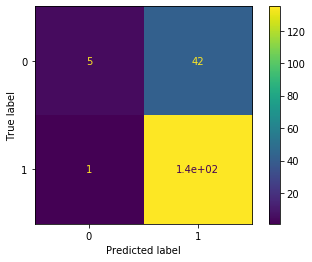

In [20]:
disp = metrics.plot_confusion_matrix(svm_clf, X_test_prepared, val_labels)
plt.show(disp)

In [21]:
joblib.dump(svm_clf, "svm_clf.pkl")

['svm_clf.pkl']

In [22]:
preds = svm_clf.predict(X_test_prepared)
tn, fp, fn, tp = metrics.confusion_matrix(val_labels, preds).ravel()
sens = (tp / (tp + fn)) * 100
spec = (tn / (tn + fp)) * 100
prec = (tp / (tp + fp)) * 100
accuracy = ((tp + tn) / (tp + tn + fn + fp)) * 100
h_mean = 2 * ((sens * spec) / (sens + spec))
f1 = 2 * ((prec * sens) / (prec + sens))

print(f"Accuracy : {accuracy}\nPrecision : {prec}\nRecall : {sens}\nSpecificity : {spec}\nH-mean : {h_mean}\nF1 score : {f1}")

Accuracy : 76.50273224043715
Precision : 76.27118644067797
Recall : 99.26470588235294
Specificity : 10.638297872340425
H-mean : 19.217081850533805
F1 score : 86.26198083067092


## KNN Classifier

In [23]:
from sklearn.neighbors import KNeighborsClassifier as knn

knn_clf = knn()
knn_clf.fit(X_train_prepared, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [24]:
y_pred = knn_clf.predict(X_test_prepared)
print(np.array(y_pred == val_labels)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == val_labels)/len(val_labels))

[ True  True False  True False  True  True  True False  True  True False  True False False  True  True  True  True
  True  True False  True  True False]

Percentage correct:  78.14207650273224


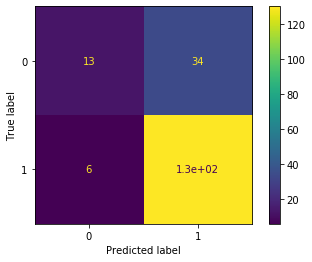

In [25]:
disp = metrics.plot_confusion_matrix(knn_clf, X_test_prepared, val_labels)
plt.show(disp)

In [26]:
joblib.dump(knn_clf, "knn_clf.pkl")

['knn_clf.pkl']

In [27]:
preds = knn_clf.predict(X_test_prepared)
tn, fp, fn, tp = metrics.confusion_matrix(val_labels, preds).ravel()
sens = (tp / (tp + fn)) * 100
spec = (tn / (tn + fp)) * 100
prec = (tp / (tp + fp)) * 100
accuracy = ((tp + tn) / (tp + tn + fn + fp)) * 100
h_mean = 2 * ((sens * spec) / (sens + spec))
f1 = 2 * ((prec * sens) / (prec + sens))

print(f"Accuracy : {accuracy}\nPrecision : {prec}\nRecall : {sens}\nSpecificity : {spec}\nH-mean : {h_mean}\nF1 score : {f1}")

Accuracy : 78.14207650273224
Precision : 79.26829268292683
Recall : 95.58823529411765
Specificity : 27.659574468085108
H-mean : 42.90429042904291
F1 score : 86.66666666666666


## Random Forest Classier

In [32]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [33]:
rf_clf.fit(X_train_prepared, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [34]:
from sklearn import metrics
preds = rf_clf.predict(X_test_prepared)
metrics.accuracy_score(val_labels, preds)

0.7486338797814208

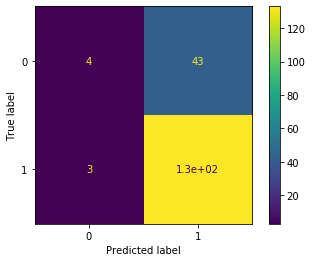

In [35]:
metrics.plot_confusion_matrix(rf_clf, X_test_prepared, val_labels)

In [36]:
joblib.dump(rf_clf, "rf_clf.pkl")

['rf_clf.pkl']

In [37]:
preds = rf_clf.predict(X_test_prepared)
tn, fp, fn, tp = metrics.confusion_matrix(val_labels, preds).ravel()
sens = (tp / (tp + fn)) * 100
spec = (tn / (tn + fp)) * 100
prec = (tp / (tp + fp)) * 100
accuracy = ((tp + tn) / (tp + tn + fn + fp)) * 100
h_mean = 2 * ((sens * spec) / (sens + spec))
f1 = 2 * ((prec * sens) / (prec + sens))

print(f"Accuracy : {accuracy}\nPrecision : {prec}\nRecall : {sens}\nSpecificity : {spec}\nH-mean : {h_mean}\nF1 score : {f1}")

Accuracy : 74.86338797814209
Precision : 75.56818181818183
Recall : 97.79411764705883
Specificity : 8.51063829787234
H-mean : 15.658572479764532
F1 score : 85.25641025641026
